In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from typing import Optional

"""
Loading the data
"""
pd.options.display.max_colwidth = 1500
pd.options.display.max_rows = 1000

df = pd.read_csv(r"books_and_genres.csv")

# drop the extra index column
df = df.drop(columns=df.columns[0])

df.head()

In [ ]:
"""
Basic formatting
"""
# stringify all text
df["text"] = df["text"].map(str)
df = df.replace({r"\r\n|\r|\n": " "}, regex=True)

df.head(5)

In [ ]:
"""
Methods that will be used in the next block to try to source a published date
"""
import re
import roman
from roman import InvalidRomanNumeralError

# regex for finding Gregorian or Roman publish dates
rn_year_regex = r"\b(.[M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3}))]{3,})\b"
modern_year_regex = r"(\b\d{4}\b)"
valid_year_regex = f"{modern_year_regex}|{rn_year_regex}"

# methods for finding above regex matches in text
find_year = re.compile("(" + rn_year_regex + "|" + modern_year_regex + ")")
find_modern_year = re.compile("(" + modern_year_regex + ")")


def is_right_era(int_date: int):
    return 1000 < int_date < 1922


def get_valid_date(date: str) -> int:
    if not date.isnumeric():
        return 0

    int_date = int(date)

    if is_right_era(int_date):
        return int_date

    return 0


def convert_date(date: str) -> int:
    if date == "no date":
        return 0

    valid_date = get_valid_date(date)
    if valid_date:
        return valid_date

    # If the number cannot be found from the string, maybe it is a roman number
    try:
        number = roman.fromRoman(date.strip())
    except (InvalidRomanNumeralError, TypeError, AttributeError) as e:
        return 0

    valid_date = get_valid_date(number)
    return valid_date

In [ ]:
"""
Try to source a published date from the intro text of each book and write to new "year" column
"""

# try to find either a Roman or Gregorian year within the text of each book, and insert into the "year" column
df["year"] = df["text"].map(lambda t: (find_year.search(t[0:1000]) or ["no date"])[0])

# no date before
print(len(df.loc[df["year"] == "no date"]))
df["year"] = df["year"].map(convert_date)

# no date after :(
print(len(df.loc[df["year"] == 0]))

In [ ]:
"""
Methods that will be used in the next block to try to source published date from Google Books
"""

import requests
import time

# ADD YOUR GOOGLE BOOKS API CLIENT SECRET HERE IF YOU WOULD LIKE TO RUN THIS PORTION
secret = ""


def is_valid_date(date: str) -> bool:
    if not date.isnumeric():
        return False

    return is_right_era(int(date))


def find_publication_year_from_item(item: dict) -> Optional[int]:
    published_date = item["volumeInfo"].get("publishedDate", "")

    if published_date and is_valid_date(published_date):
        return published_date

    # if there is no valid publishedDate, search in the description text of the response
    description = item["volumeInfo"].get("description", "")
    possible_dates = [
        date[0]
        for date in find_modern_year.findall(description)
        if is_valid_date(date[0])
    ]
    if possible_dates:
        return min(possible_dates)


# check the Google Books API by a book's title in order to get the publication year
def get_publication_year(title: str) -> Optional[int]:
    if not secret:
        print(
            'Please assign value to "secret" variable above with your Google Books API key'
        )
        return

    # avoid per-minute rate limiting
    time.sleep(0.05)
    url = f"https://www.googleapis.com/books/v1/volumes?q={title}&key={secret}"
    response = requests.get(url)

    items = response.json().get("items")
    if not items:
        print("No matches found for ", title, response.json())
        return 0

    possible_years = [
        found
        for item in items
        if (found := find_publication_year_from_item(item)) is not None
    ]

    if possible_years:
        year = min(possible_years)
        print(f"{title}: {year}")
        return year

    print("could not find year for title ", title)
    return 0

In [ ]:
"""
Loop over the rows missing a publication year and run the above methods to attempt to fill it.
This needs to be done in batches because of rate limiting.

CSV with saved results imported in file in leui of live fetching. See commented out block below
if you would like to test it (you will need a Google Book API client key)
"""

# If you would like to test this out, uncomment the block below and use your own secret key in the block above
# dfcopy = df.copy()[0:100]
# dfcopy.loc[dfcopy['year'] == 0, 'year'] = dfcopy.loc[dfcopy['year'] == 0]['title'].apply(get_publication_year)

# read from the already compiled set instead of fetching live from Google Books API
dfFull = pd.read_csv("fullset.csv")

# Extra formatting!
# Force the year into an int and the text into a string
dfFull.year = dfFull.year.astype("int")
dfFull["text"] = dfFull["text"].astype(str)

# Drop the "genres" column as we will not use it
dfFull = dfFull.drop("genres", axis=1)
dfFull.head(3)

In [ ]:
"""
Helper method to determine whether a certain book has adequately long text
"""
MIN_FULL_TEXT = 15000


def is_acceptable_length(text: str, length: int = MIN_FULL_TEXT):
    if not isinstance(text, str) or len(text) < length:
        return False

    return True

In [ ]:
print("Book count before removing undated and outliers: ", len(dfFull))

print(
    "Number of books without dates to be removed: ", len(dfFull.loc[dfFull.year == 0])
)
dfFull = dfFull.drop(dfFull[dfFull.year == 0].index)

# drop the books from before 1775 - not enough examples
print(
    "Number of books from before 1775, to be removed: ",
    len(dfFull.loc[dfFull.year < 1775]),
)
dfFull = dfFull.drop(dfFull[dfFull.year < 1775].index)

# drop books after 1922 - these are errors
print(
    "Number of books from after 1922, to be removed: ",
    len(dfFull.loc[dfFull.year > 1922]),
)
dfFull = dfFull.drop(dfFull[dfFull.year > 1922].index)

# drop any books without text or not enough text
print(
    "Number of books with too short or absent text, to be removed: ",
    len(dfFull[dfFull.text.apply(is_acceptable_length) == False]),
)
dfFull = dfFull.drop(dfFull[dfFull.text.apply(is_acceptable_length) == False].index)

print("Dropping duplicates")
dfFull = dfFull.drop_duplicates(subset="title", keep="first")

print("New book count: ", len(dfFull))

dfFull.head()

Histogram of the distribution of publication year. Data is heavily skewed towards the later years of the set. The first 75 years of the dataset contains only ~1/3 of the total amount of books, while the last 72 years of the date range of the set contains 2/3rds of the total books. A full 45% of the books are from 1900-1922.

In [ ]:
import matplotlib.pyplot as plt

# uncomment this statement to see the count for each year
# print(dfFull['year'].value_counts(ascending=True).sort_index())
print(
    f"Between 1775-1850 books: {round(len(dfFull.loc[dfFull.year < 1875]) / len(dfFull) * 100)}%"
)
print(
    f"Between 1850-1900 books:{round(len(dfFull.loc[(dfFull.year >= 1875) & (dfFull.year < 1900)]) / len(dfFull) * 100)}%"
)
print(
    f"Between 1900-1922 books: {round(len(dfFull.loc[(dfFull.year >= 1900) & (dfFull.year <= 1922)]) / len(dfFull) * 100)}%"
)

dfFull.plot(kind="hist", title="Publication Year")
plt.suptitle(
    "Distribution of books across year published",
    x=0.5,
    y=1.05,
    ha="center",
    fontsize="x-large",
)

In [ ]:
"""
Define testing and training books
"""
# testing books are every 5th book for each year according to the original dataset
# or if there are fewer than 5 books, the first book.
testing_books = []
did_it = []

for year in range(1775, 1923):
    books_from_year = list(dfFull[dfFull.year == year].index)
    if len(books_from_year) < 5:
        testing_books.append(books_from_year[0])
    testing_books.extend(books_from_year[::5])  # we want 20% testing dat


def get_is_testing(row):
    if row.name in testing_books:
        did_it.append(row.name)
        row["test"] = True
    else:
        row["test"] = False
    return row


dfFull = dfFull.apply(get_is_testing, axis=1)

To have a more even distribution of the dataset, as well as to have more manageable data points that the text of an entire book, I create 200 data points for each year represented in the set. The 200 points are 5000 character portions of the books attributed to that year. For years with only a few books, the points from that year will have less variety, perhaps yielding worse results than the years with a variety of different books. I do this before tokenizing and other processing the text as the process will be less intense once the texts have been truncated.

In [ ]:
"""
Create new dataframe for final data. Each year will have 200 rows, each with a unique portion of text sourced
from a book published in that year
"""

all_years = []
PER_YEAR_COUNT = 200

for year in range(1775, 1923):
    years = [year] * PER_YEAR_COUNT
    all_years.extend(years)

print(len(all_years))
dfPas = pd.DataFrame(columns=["title", "passage", "year", "test"])
dfPas["year"] = all_years
dfPas["index"] = dfPas.index

pd.concat([dfPas.head(2), dfPas.tail(2)])

In [ ]:
import random
import copy

PASSAGE_LENGTH = 5000

dfFullCopy = dfFull.copy()
no_continue_list = []


def get_full_text(row):
    index = row["index"]
    index_for_year = index % PER_YEAR_COUNT

    books_from_year = list(dfFullCopy[dfFullCopy.year == row["year"]].index)

    # we have exhausted all the text from the books from this year. There are a few "bad" years with only 4 books
    if not len(books_from_year):
        print(f"THERE ARE NO BOOKS LEFT FOR {row.year}. NOT CONTINUING WITH THIS YEAR.")
        raise ValueError("Depleted books")

    index_in_book_list = index_for_year % len(books_from_year)
    book_index = books_from_year[index_in_book_list]

    book = dfFullCopy.loc[book_index]
    is_test = book["test"]
    full_text = copy.copy(book["text"])

    return full_text, book_index, book["title"], is_test


def get_passage(row):
    if row["year"] in no_continue_list:
        return

    try:
        full_text, book_index, book_title, is_test = get_full_text(row)
    except ValueError:
        no_continue_list.append(row["year"])
        return

    # # testing books are every 5th book for each year according to the original dataset
    # # or if there are fewer than 5 books, the first book.
    # books_from_year_original = list(dfFull[dfFull.year == row['year']].index)
    # testing_books = books_from_year_original[::5]
    # row['test'] = book_index == 0 if len(books_from_year_original) < 5 else book_index in testing_books

    # print(f'Creating excerpt for {row.year}: from {book_title}.')

    max_start_point = len(full_text) - PASSAGE_LENGTH
    start_point = random.randint(0, max_start_point)
    end_point = start_point + PASSAGE_LENGTH
    passage = full_text[start_point:end_point]

    if not len(passage) == PASSAGE_LENGTH:
        print(f"SOMETHING WENT WRONG FOR BOOK {book_title}")
        return

    # Remove the used text from the original dataframe if remaining text is less than the passage length, remove the book
    # Otherwise remove the used text from the existing full text and replace the modified text in the original df
    full_text_modified = full_text[:start_point] + full_text[end_point:]
    if len(full_text_modified) < PASSAGE_LENGTH:
        print(f"dropping book: {book_title} at index {book_index} from year {row.year}")
        dfFullCopy.drop([book_index], inplace=True)
    else:
        dfFullCopy.at[book_index, "text"] = full_text_modified
        new_text_length = len(dfFullCopy.loc[book_index]["text"])

        if not new_text_length < len(full_text):
            print(f"SOMETHING WENT WRONG FOR BOOK {book_title}")
            return

    row["passage"] = passage
    row["title"] = book_title
    row["test"] = is_test
    # print(f'Success! {len(row.passage)} char passage created for {book_title}.')

    return row


dfPas = dfPas.apply(get_passage, axis=1)
pd.concat([dfPas.head(2), dfPas.tail(2)])

In [ ]:
# histogram of datapoint distribution across years
dfPas.hist(column="year", bins=148)

In [ ]:
"""
Delete rows without passages (from depleted years)
"""
print("Count before removal ", dfPas.shape[0])
dfPas = dfPas.drop(
    dfPas[dfPas.passage.apply(is_acceptable_length, length=5000) == False].index
)
print("Count after removal ", dfPas.shape[0])

In [ ]:
dfGrouped = (
    dfPas.groupby(["test"])["test"]
    .count()
    .reset_index(name="Count")
    .sort_values(["Count"], ascending=False)
)

print(dfGrouped.head())

In [ ]:
from sklearn.utils import shuffle

dfPas = dfPas.copy()
dfPas = dfPas.drop(columns=["index"])
dfPas = shuffle(dfPas, random_state=1)
dfPas = dfPas.reset_index(drop=True)
dfPas.head()

In [ ]:
dfTest = dfPas[dfPas["test"] == True].drop(columns=["test"]).reset_index(drop=True)
dfTrain = dfPas[dfPas["test"] == False].drop(columns=["test"]).reset_index(drop=True)
print("Training count: ", dfTrain.shape[0])
print("Testing count: ", dfTest.shape[0])

test_books = set(dfTest["title"].values.tolist())
train_books = set(dfTrain["title"].values.tolist())
books_in_common = [book for book in test_books if book in train_books]

print("Number of books in commong between the sets: ", len(books_in_common))

# dfTest.to_csv('testing.csv', index=False)
# dfTrain.to_csv('training.csv', index=False)

print(dfTest.head(2))

All of the years are evenly distributed, except for three years that had very sparse data - less than four books each. 1781 only has 77 instances, 1791 only 87 instances, and 1784 has 166. This may yield less exact results for these years. In general, pre-1825 results will be worse than post-1825 as the amount of books available is relatively low for these years, meaning that there is less variety of examples of each year's text.

We have manually separate the training and testing data in the methods above rather than using a library. This is because we do not want to train the model to fit a specific book, but rather a specific year, therefor we must ensure that each book is either exclusively in the testing set or in the training set. The split comes to roughly 27% testing and 63% training

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing

MAX_WORDS = 10000

x_test = dfTest["passage"]
y_test = dfTest["year"]

x_train = dfTrain["passage"]
y_train = dfTrain["year"]

# Create a tokenizer to feed to the embedding layer
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
import numpy as np

MAX_LENGTH = 700

vocab_size = len(tokenizer.word_index)
print(vocab_size)

# Padding to make all batches has equal length
x_train = pad_sequences(x_train, padding="post", maxlen=MAX_LENGTH)
x_test = pad_sequences(x_test, padding="post", maxlen=MAX_LENGTH)


# Get word to vev from pretrained glove embeddings
embeddings_dictionary = dict()
glove_file = open("glove.6B/glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    values = line.split()
    word = values[0]
    vector_dimensions = np.asarray(values[1:], dtype="float32")
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()
print(f"Found {len(embeddings_dictionary)} word vectors")

In [ ]:
# If glove embeddings has an embedding for word in our tokenizer, add it to embedding matrix
EMBEDDING_DIMENSION = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIMENSION))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index - 1] = embedding_vector

In [ ]:
"""
Try as regression
"""
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIMENSION, input_length=MAX_LENGTH))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(1))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()

model.compile(optimizer=Adam(learning_rate=0.1), loss="mean_squared_error")

history = model.fit(
    x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test)
)

In [ ]:
def get_predictions(current_model: tensorflow.keras.Model, test_x):
    test_array = np.array(test_x)
    return current_model.predict(test_array)


def create_scatterplot(test_x, test_y, current_model: tensorflow.keras.Model, title: str, category=False):
    predictions = get_predictions(current_model, test_x)
    plt.rcParams["figure.figsize"] = [8, 6]
    plt.axis([1775, 1922, 1725, 2000])
    plt.scatter(x=test_y, y=predictions, color="blue", alpha=0.2, s=10)
    plt.scatter(x=test_y, y=test_y, color="pink", alpha=0.2, s=10)
    plt.title(title)
    plt.xlabel("Actual Years")
    plt.ylabel("Predicted Years")
    plt.show()


create_scatterplot(x_test, y_test, model, "Model 1: three dense layers, MSE")

In [ ]:
from sklearn import metrics


def get_MSE_and_MAE(current_model: tensorflow.keras.Model, test_x):
    predictions = get_predictions(current_model, test_x)
    print(
        "Mean squared error: ", np.sqrt(metrics.mean_squared_error(y_test, predictions))
    )
    print(
        "Mean absolute error: ",
        np.sqrt(metrics.mean_absolute_error(y_test, predictions)),
    )


get_MSE_and_MAE(model, x_test)

In [ ]:
def plot_loss(score: float):
    print("Test Score:", score)

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])

    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()


plot_loss(model.evaluate(x_test, y_test, verbose=1))

In [ ]:
"""
Try same params but with mean absolute error loss function
"""
model2 = Sequential()
model2.add(Embedding(vocab_size, EMBEDDING_DIMENSION, input_length=MAX_LENGTH))
model2.add(Flatten())
model2.add(Dense(512, activation="relu"))
model2.add(Dense(256, activation="relu"))
model2.add(Dense(1))
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False
model2.summary()

model2.compile(optimizer=Adam(learning_rate=0.1), loss="mean_absolute_error")

history = model2.fit(
    x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test)
)

In [ ]:
create_scatterplot(x_test, y_test, model2, "Model 2: three dense layers, MAE")

In [ ]:
get_MSE_and_MAE(model2, x_test)

In [ ]:
from keras.layers import SimpleRNN

"""
Using SIMPLE RNN
"""
model3 = Sequential()
model3.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model3.add(SimpleRNN(units=32))
model3.add(Dense(512, activation="relu"))
model3.add(Dense(256, activation="relu"))
model3.add(Dense(1))
model3.layers[0].trainable = False
model3.summary()
model3.compile(loss="mean_absolute_error", optimizer="adam")

history = model3.fit(
    x_train, y_train, epochs=12, batch_size=64, validation_data=(x_test, y_test)
)

In [ ]:
create_scatterplot(x_test, y_test, model3, "Model 2: Simple RNN")

In [ ]:
get_MSE_and_MAE(model3, x_test)

In [ ]:
plot_loss(model3.evaluate(x_test, y_test, verbose=1))

In [ ]:
from keras.layers import LSTM

"""
Using LSTM - (reads from both sides)
"""
model4 = Sequential()
model4.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model4.add(LSTM(units=32))
model4.add(Dense(512, activation="relu"))
model4.add(Dense(256, activation="relu"))
model4.add(Dense(128, activation="relu"))
model4.add(Dense(1))
model4.layers[0].trainable = False
model4.summary()
model4.compile(loss="mean_absolute_error", optimizer="adam")

history = model4.fit(
    x_train, y_train, epochs=10, batch_size=256, validation_data=(x_test, y_test)
)

In [ ]:
create_scatterplot(x_test, y_test, model4, "Model 4")

In [ ]:
"""
Separate into eras
"""


def write_era(row):
    if row["year"] < 1820:
        row["era"] = 1
    elif 1820 <= row["year"] < 1870:
        row["era"] = 2
    elif row["year"] >= 1870:
        row["era"] = 3
    return row


dfTest2 = dfTest.copy()
dfTrain2 = dfTrain.copy()
dfTest2 = dfTest2.apply(write_era, axis=1)
dfTrain2 = dfTrain2.apply(write_era, axis=1)

dfTest2.head(2)

In [ ]:
dfTest2.hist()

In [ ]:
x_test_era = dfTest2["passage"]
y_test_era = dfTest2["era"]

x_train_era = dfTrain2["passage"]
y_train_era = dfTrain2["era"]

# Get labels and make them suitable for training. [1,2,3] -> [0,1,2]
label_encoder = preprocessing.LabelEncoder()
y_test_era = label_encoder.fit_transform(y_test_era)
y_train_era = label_encoder.fit_transform(y_train_era)

# One hot encode the labels
y_train_era = to_categorical(y_train_era)
y_test_era = to_categorical(y_test_era)

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train_era)

x_train_era = tokenizer.texts_to_sequences(x_train_era)
x_test_era = tokenizer.texts_to_sequences(x_test_era)

In [ ]:
import numpy as np

vocab_size = len(tokenizer.word_index)

x_train_era = pad_sequences(x_train_era, padding="post", maxlen=MAX_LENGTH)
x_test_era = pad_sequences(x_test_era, padding="post", maxlen=MAX_LENGTH)

embeddings_dictionary = dict()
glove_file = open("glove.6B/glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    values = line.split()
    word = values[0]
    vector_dimensions = np.asarray(values[1:], dtype="float32")
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()
print(f"Found {len(embeddings_dictionary)} word vectors")

In [ ]:
EMBEDDING_DIMENSION = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIMENSION))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index - 1] = embedding_vector

In [ ]:
model5 = Sequential()
model5.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model5.add(LSTM(256, return_sequences=True))
model5.add(LSTM(128, return_sequences=True))
model5.add(LSTM(32))
model5.add(Dense(3, activation="softmax"))
model5.layers[0].trainable = False
model5.summary()

model5.compile(
    optimizer=Adam(learning_rate=0.01), metrics=["acc"], loss="categorical_crossentropy"
)

history = model2.fit(
    x_train_era,
    y_train_era,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_data=(x_test_era, y_test_era),
)

In [ ]:
def create_confusion_matrix(current_model):
    y_prediction = current_model.predict(x_test_era)
    rounded_y = np.argmax(y_test_era, axis=1)
    rounded_predictions = np.argmax(y_prediction, axis=1)

    # Create the confusion matrix
    confusion_matrix = metrics.confusion_matrix(rounded_y, rounded_predictions)
    cm_df = pd.DataFrame(
        confusion_matrix,
        index=["early", "mid", "late"],
        columns=["early", "mid", "late"],
    )

    # Plotting the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, fmt=".2f", annot=True)
    plt.title("Confusion Matrix")
    plt.ylabel("Actal Values")
    plt.xlabel("Predicted Values")
    plt.show()


create_confusion_matrix(model5)

In [ ]:
model6 = Sequential()
model6.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model6.add(LSTM(32))
model6.add(Dense(3, activation="softmax"))
model6.add(Flatten())
model6.layers[0].trainable = False
model6.summary()

model6.compile(
    optimizer=Adam(learning_rate=0.01), metrics=["acc"], loss="categorical_crossentropy"
)

history = model.fit(
    x_train_era,
    y_train_era,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(x_test_era, y_test_era),
)

In [ ]:
create_confusion_matrix(model6)

In [ ]:
model7 = Sequential()
model7.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model7.add(LSTM(256))
model7.add(Dense(3, activation="softmax"))
model7.add(Flatten())
model7.layers[0].trainable = False
model7.summary()

model7.compile(
    optimizer=Adam(learning_rate=0.01), metrics=["acc"], loss="categorical_crossentropy"
)

history = model.fit(
    x_train_era,
    y_train_era,
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_data=(x_test_era, y_test_era),
)

In [ ]:
create_confusion_matrix(model)

In [ ]:
"""
Try same params but with mean absolute error loss function
"""
model2 = Sequential()
model2.add(Embedding(vocab_size, EMBEDDING_DIMENSION, input_length=MAX_LENGTH))
model2.add(Flatten())
model2.add(Dense(512, activation="relu"))
model2.add(Dense(256, activation="relu"))
model2.add(Dense(1))
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False
model2.summary()

model2.compile(optimizer=Adam(learning_rate=0.1), loss="mean_absolute_error")

history = model2.fit(
    x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test)
)

In [ ]:
create_scatterplot(x_test, y_test, model2, "Model 2: three dense layers, MAE")

In [ ]:
get_MSE_and_MAE(model2, x_test)

In [ ]:
from keras.layers import SimpleRNN

"""
Using SIMPLE RNN
"""
model3 = Sequential()
model3.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model3.add(SimpleRNN(units=32))
model3.add(Dense(512, activation="relu"))
model3.add(Dense(256, activation="relu"))
model3.add(Dense(1))
model3.layers[0].trainable = False
model3.summary()
model3.compile(loss="mean_absolute_error", optimizer="adam")

history = model3.fit(
    x_train, y_train, epochs=12, batch_size=64, validation_data=(x_test, y_test)
)

In [ ]:
create_scatterplot(x_test, y_test, model3, "Model 2: Simple RNN")

In [ ]:
get_MSE_and_MAE(model3, x_test)

In [ ]:
plot_loss(model3.evaluate(x_test, y_test, verbose=1))

In [ ]:
from keras.layers import LSTM

"""
Using LSTM - (reads from both sides)
"""
model4 = Sequential()
model4.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model4.add(LSTM(units=32))
model4.add(Dense(512, activation="relu"))
model4.add(Dense(256, activation="relu"))
model4.add(Dense(128, activation="relu"))
model4.add(Dense(1))
model4.layers[0].trainable = False
model4.summary()
model4.compile(loss="mean_absolute_error", optimizer="adam")

history = model4.fit(
    x_train, y_train, epochs=10, batch_size=256, validation_data=(x_test, y_test)
)

In [ ]:
create_scatterplot(x_test, y_test, model4, "Model 4")

In [ ]:
"""
Separate into eras
"""


def write_era(row):
    if row["year"] < 1820:
        row["era"] = 1
    elif row["year"] >= 1820 and row["year"] < 1870:
        row["era"] = 2
    elif row["year"] >= 1870:
        row["era"] = 3
    return row


dfTest2 = dfTest.copy()
dfTrain2 = dfTrain.copy()
dfTest2 = dfTest2.apply(write_era, axis=1)
dfTrain2 = dfTrain2.apply(write_era, axis=1)

dfTest2.head(2)

In [ ]:
dfTest2.hist()

In [ ]:
x_test_era = dfTest2["passage"]
y_test_era = dfTest2["era"]

x_train_era = dfTrain2["passage"]
y_train_era = dfTrain2["era"]

label_encoder = preprocessing.LabelEncoder()
y_test_era = label_encoder.fit_transform(y_test_era)
y_train_era = label_encoder.fit_transform(y_train_era)

y_train_era = to_categorical(y_train_era)
y_test_era = to_categorical(y_test_era)

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train_era)

x_train_era = tokenizer.texts_to_sequences(x_train_era)
x_test_era = tokenizer.texts_to_sequences(x_test_era)

In [ ]:
import numpy as np

vocab_size = len(tokenizer.word_index)

x_train_era = pad_sequences(x_train_era, padding="post", maxlen=MAX_LENGTH)
x_test_era = pad_sequences(x_test_era, padding="post", maxlen=MAX_LENGTH)

embeddings_dictionary = dict()
glove_file = open("glove.6B/glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    values = line.split()
    word = values[0]
    vector_dimensions = np.asarray(values[1:], dtype="float32")
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()
print(f"Found {len(embeddings_dictionary)} word vectors")

In [ ]:
EMBEDDING_DIMENSION = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIMENSION))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index - 1] = embedding_vector

In [ ]:
model5 = Sequential()
model5.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model5.add(LSTM(256, return_sequences=True))
model5.add(LSTM(128, return_sequences=True))
model5.add(LSTM(32))
model5.add(Dense(3, activation="softmax"))
model5.layers[0].trainable = False
model5.summary()

model5.compile(
    optimizer=Adam(learning_rate=0.01), metrics=["acc"], loss="categorical_crossentropy"
)

history = model2.fit(
    x_train_era,
    y_train_era,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_data=(x_test_era, y_test_era),
)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def create_confusion_matrix(current_model):
    y_prediction = current_model.predict(x_test_era)
    rounded_y = np.argmax(y_test_era, axis=1)
    rounded_predictions = np.argmax(y_prediction, axis=1)

    # Create the confusion matrix
    confusion_matrix = metrics.confusion_matrix(rounded_y, rounded_predictions)
    cm_df = pd.DataFrame(
        confusion_matrix,
        index=["early", "mid", "late"],
        columns=["early", "mid", "late"],
    )

    # Plotting the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, fmt=".2f", annot=True)
    plt.title("Confusion Matrix")
    plt.ylabel("Actal Values")
    plt.xlabel("Predicted Values")
    plt.show()


create_confusion_matrix(model5)

In [ ]:
model6 = Sequential()
model6.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model6.add(LSTM(32))
model6.add(Dense(3, activation="softmax"))
model6.add(Flatten())
model6.layers[0].trainable = False
model6.summary()

model6.compile(
    optimizer=Adam(learning_rate=0.01), metrics=["acc"], loss="categorical_crossentropy"
)

history = model.fit(
    x_train_era,
    y_train_era,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(x_test_era, y_test_era),
)

In [ ]:
create_confusion_matrix(model6)

In [ ]:
model7 = Sequential()
model7.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model7.add(LSTM(256))
model7.add(Dense(3, activation="softmax"))
model7.add(Flatten())
model7.layers[0].trainable = False
model7.summary()

model7.compile(
    optimizer=Adam(learning_rate=0.01), metrics=["acc"], loss="categorical_crossentropy"
)

history = model.fit(
    x_train_era,
    y_train_era,
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_data=(x_test_era, y_test_era),
)

In [ ]:
create_confusion_matrix(model)

In [103]:
get_MSE_and_MAE(model2, x_test)

Mean squared error:  73.50422415554384
Mean absolute error:  7.620125635573291


In [122]:
from keras.layers import SimpleRNN

"""
Using SIMPLE RNN
"""
model3 = Sequential()
model3.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model3.add(SimpleRNN(units=32))
model3.add(Dense(512, activation="relu"))
model3.add(Dense(256, activation="relu"))
model3.add(Dense(1))
model3.layers[0].trainable = False
model3.summary()
model3.compile(loss="mean_absolute_error", optimizer="adam")

history = model3.fit(
    x_train, y_train, epochs=12, batch_size=64, validation_data=(x_test, y_test)
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 700, 100)          41553000  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_24 (Dense)            (None, 512)               16896     
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dense_26 (Dense)            (None, 1)                 257       
                                                                 
Total params: 41,705,737
Trainable params: 152,737
Non-trainable params: 41,553,000
_________________________________________________________________
Epoch 1/12
356/356 [================

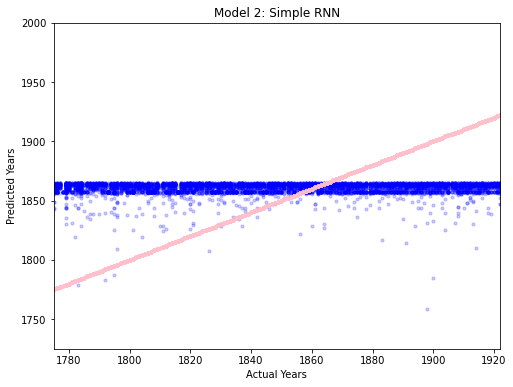

In [123]:
create_scatterplot(x_test, y_test, model3, "Model 2: Simple RNN")

In [124]:
get_MSE_and_MAE(model3, x_test)

Mean squared error:  45.86673616720356
Mean absolute error:  6.259506012182008


205/205 [==============================] - 3s 14ms/step - loss: 39.1814
Test Score: 39.18141555786133


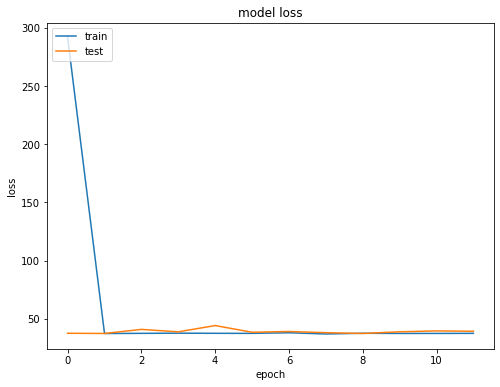

In [125]:
plot_loss(model3.evaluate(x_test, y_test, verbose=1))

In [142]:
from keras.layers import LSTM

"""
Using LSTM - (reads from both sides)
"""
model4 = Sequential()
model4.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model4.add(LSTM(units=32))
model4.add(Dense(512, activation="relu"))
model4.add(Dense(256, activation="relu"))
model4.add(Dense(128, activation="relu"))
model4.add(Dense(1))
model4.layers[0].trainable = False
model4.summary()
model4.compile(loss="mean_absolute_error", optimizer="adam")

history = model4.fit(
    x_train, y_train, epochs=10, batch_size=256, validation_data=(x_test, y_test)
)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 700, 100)          41553000  
                                                                 
 lstm_4 (LSTM)               (None, 32)                17024     
                                                                 
 dense_43 (Dense)            (None, 512)               16896     
                                                                 
 dense_44 (Dense)            (None, 256)               131328    
                                                                 
 dense_45 (Dense)            (None, 128)               32896     
                                                                 
 dense_46 (Dense)            (None, 1)                 129       
                                                                 
Total params: 41,751,273
Trainable params: 198,273
No

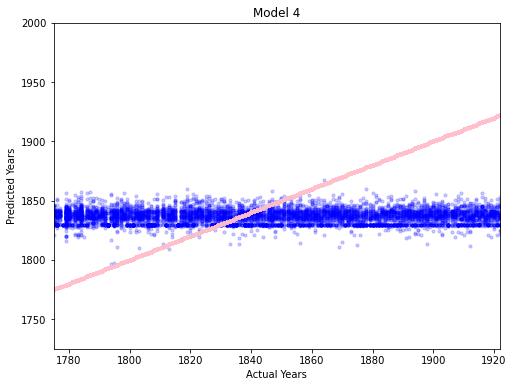

In [143]:
create_scatterplot(x_test, y_test, model4, "Model 4")

In [393]:
"""
Separate into eras
"""


def write_era(row):
    if row["year"] < 1820:
        row["era"] = 1
    elif row["year"] >= 1820 and row["year"] < 1870:
        row["era"] = 2
    elif row["year"] >= 1870:
        row["era"] = 3
    return row


dfTest2 = dfTest.copy()
dfTrain2 = dfTrain.copy()
dfTest2 = dfTest2.apply(write_era, axis=1)
dfTrain2 = dfTrain2.apply(write_era, axis=1)

dfTest2.head(2)

,title,passage,year,era
0,on the origin of species,"hypothesis; or rather I ought to say we shall have proved it as far as certainty is possible for us; for, after all, there is no one of our surest convictions which may not be upset, or at any rate modified by a further accession of knowledge. It was because it satisfied these conditions that we accepted the hypothesis as to the disappearance of the tea-pot and spoons in the case I supposed in a previous lecture; we found that our hypothesis on that subject was tenable and valid, because the supposed cause existed in nature, because it was competent to account for the phenomena, and because no other known cause was competent to account for them; and it is upon similar grounds that any hypothesis you choose to name is accepted in science as tenable and valid. What is Mr. Darwin's hypothesis? As I apprehend it--for I have put it into a shape more convenient for common purposes than I could find 'verbatim' in his book--as I apprehend it, I say, it is, that all the phenomena of organic nature, past and present, result from, or are caused by, the inter-action of those properties of organic matter, which we have called ATAVISM and VARIABILITY, with the CONDITIONS OF EXISTENCE; or, in other words,--given the existence of organic matter, its tendency to transmit its properties, and its tendency occasionally to vary; and, lastly, given the conditions of existence by which organic matter is surrounded--that these put together are the causes of the Present and of the Past condition...",1831.0,2
1,ferragus,"in all things beside his wife, even in her caprices; in fact, he would have been uneasy if she had none, thinking it a symptom of some illness. Auguste de Maulincour had the personal misfortune of running against this passion, and falling in love with the wife beyond recovery. Nevertheless, though he carried in his heart so intense a love, he was not ridiculous; he complied with all the demands of society, and of military manners and customs. And yet his face wore constantly, even though he might be drinking a glass of champagne, that dreamy look, that air of silently despising life, that nebulous expression which belongs, though for other reasons, to _blases_ men,--men dissatisfied with hollow lives. To love without hope, to be disgusted with life, constitute, in these days, a social position. The enterprise of winning the heart of a sovereign might give, perhaps, more hope than a love rashly conceived for a happy woman. Therefore Maulincour had sufficient reason to be grave and gloomy. A queen has the vanity of her power; the height of her elevation protects her. But a pious _bourgeoise_ is like a hedgehog, or an oyster, in its rough wrappings. At this moment the young officer was beside his unconscious mistress, who certainly was unaware that she was doubly faithless. Madame Jules was seated, in a naive attitude, like the least artful woman in existence, soft and gentle, full of a majestic serenity. What an abyss is human nature! Before beginning a conversation, the ...",1820.0,2


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'era'}>]], dtype=object)

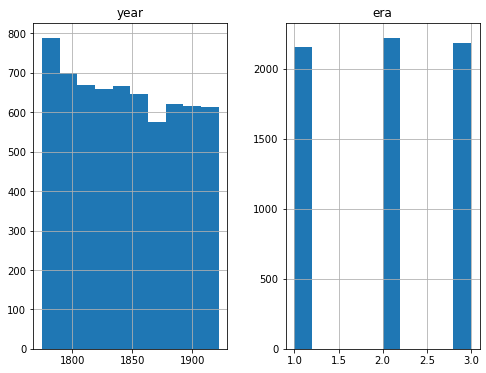

In [394]:
dfTest2.hist()

In [395]:
x_test_era = dfTest2["passage"]
y_test_era = dfTest2["era"]

x_train_era = dfTrain2["passage"]
y_train_era = dfTrain2["era"]

label_encoder = preprocessing.LabelEncoder()
y_test_era = label_encoder.fit_transform(y_test_era)
y_train_era = label_encoder.fit_transform(y_train_era)

y_train_era = to_categorical(y_train_era)
y_test_era = to_categorical(y_test_era)

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train_era)

x_train_era = tokenizer.texts_to_sequences(x_train_era)
x_test_era = tokenizer.texts_to_sequences(x_test_era)

In [396]:
import numpy as np

vocab_size = len(tokenizer.word_index)

x_train_era = pad_sequences(x_train_era, padding="post", maxlen=MAX_LENGTH)
x_test_era = pad_sequences(x_test_era, padding="post", maxlen=MAX_LENGTH)

embeddings_dictionary = dict()
glove_file = open("glove.6B/glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    values = line.split()
    word = values[0]
    vector_dimensions = np.asarray(values[1:], dtype="float32")
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()
print(f"Found {len(embeddings_dictionary)} word vectors")

Found 400001 word vectors


In [397]:
EMBEDDING_DIMENSION = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIMENSION))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index - 1] = embedding_vector

In [398]:
model5 = Sequential()
model5.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model5.add(LSTM(256, return_sequences=True))
model5.add(LSTM(128, return_sequences=True))
model5.add(LSTM(32))
model5.add(Dense(3, activation="softmax"))
model5.layers[0].trainable = False
model5.summary()

model5.compile(
    optimizer=Adam(learning_rate=0.01), metrics=["acc"], loss="categorical_crossentropy"
)

history = model2.fit(
    x_train_era,
    y_train_era,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_data=(x_test_era, y_test_era),
)

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_62 (Embedding)    (None, 50, 100)           41553000  
                                                                 
 lstm_70 (LSTM)              (None, 50, 256)           365568    
                                                                 
 lstm_71 (LSTM)              (None, 50, 128)           197120    
                                                                 
 lstm_72 (LSTM)              (None, 32)                20608     
                                                                 
 dense_115 (Dense)           (None, 3)                 99        
                                                                 
Total params: 42,136,395
Trainable params: 583,395
Non-trainable params: 41,553,000
_________________________________________________________________
Epoch 1/10
178/178 [===============

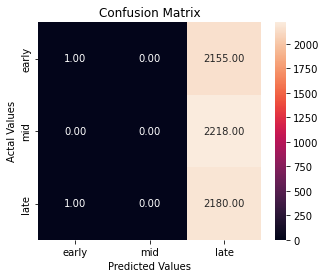

In [399]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def create_confusion_matrix(current_model):
    y_prediction = current_model.predict(x_test_era)
    rounded_y = np.argmax(y_test_era, axis=1)
    rounded_predictions = np.argmax(y_prediction, axis=1)

    # Create the confusion matrix
    confusion_matrix = metrics.confusion_matrix(rounded_y, rounded_predictions)
    cm_df = pd.DataFrame(
        confusion_matrix,
        index=["early", "mid", "late"],
        columns=["early", "mid", "late"],
    )

    # Plotting the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, fmt=".2f", annot=True)
    plt.title("Confusion Matrix")
    plt.ylabel("Actal Values")
    plt.xlabel("Predicted Values")
    plt.show()


create_confusion_matrix(model5)

In [400]:
model6 = Sequential()
model6.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model6.add(LSTM(32))
model6.add(Dense(3, activation="softmax"))
model6.add(Flatten())
model6.layers[0].trainable = False
model6.summary()

model6.compile(
    optimizer=Adam(learning_rate=0.01), metrics=["acc"], loss="categorical_crossentropy"
)

history = model.fit(
    x_train_era,
    y_train_era,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(x_test_era, y_test_era),
)

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_63 (Embedding)    (None, 50, 100)           41553000  
                                                                 
 lstm_73 (LSTM)              (None, 32)                17024     
                                                                 
 dense_116 (Dense)           (None, 3)                 99        
                                                                 
 flatten_38 (Flatten)        (None, 3)                 0         
                                                                 
Total params: 41,570,123
Trainable params: 17,123
Non-trainable params: 41,553,000
_________________________________________________________________
Epoch 1/10
712/712 [==============================] - 37s 52ms/step - loss: 1.1475 - acc: 0.3514 - val_loss: 1.1515 - val_acc: 0.3312
Epoch 2/10
712/712 [==============

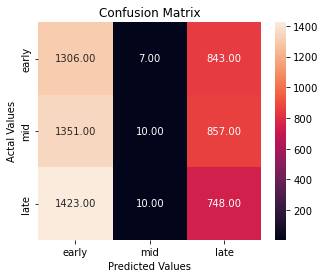

In [401]:
create_confusion_matrix(model6)

In [402]:
model7 = Sequential()
model7.add(
    Embedding(
        vocab_size,
        EMBEDDING_DIMENSION,
        weights=[embedding_matrix],
        input_length=MAX_LENGTH,
    )
)
model7.add(LSTM(256))
model7.add(Dense(3, activation="softmax"))
model7.add(Flatten())
model7.layers[0].trainable = False
model7.summary()

model7.compile(
    optimizer=Adam(learning_rate=0.01), metrics=["acc"], loss="categorical_crossentropy"
)

history = model.fit(
    x_train_era,
    y_train_era,
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_data=(x_test_era, y_test_era),
)

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_64 (Embedding)    (None, 50, 100)           41553000  
                                                                 
 lstm_74 (LSTM)              (None, 256)               365568    
                                                                 
 dense_117 (Dense)           (None, 3)                 771       
                                                                 
 flatten_39 (Flatten)        (None, 3)                 0         
                                                                 
Total params: 41,919,339
Trainable params: 366,339
Non-trainable params: 41,553,000
_________________________________________________________________
Epoch 1/10
89/89 [==============================] - 15s 164ms/step - loss: 1.1063 - acc: 0.3581 - val_loss: 1.1200 - val_acc: 0.3339
Epoch 2/10
89/89 [================

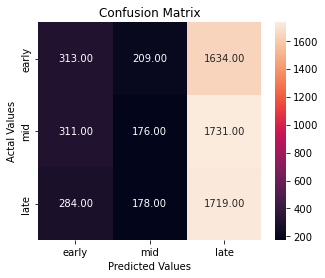

In [403]:
create_confusion_matrix(model)